The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


Epoch 0/1500 | Train Loss: 0.4404 | Val Loss: 0.5651
Epoch 20/1500 | Train Loss: 0.1912 | Val Loss: 0.2186
Epoch 40/1500 | Train Loss: 0.1080 | Val Loss: 0.1349
Epoch 60/1500 | Train Loss: 0.0819 | Val Loss: 0.0853
Epoch 80/1500 | Train Loss: 0.0638 | Val Loss: 0.0634
Epoch 100/1500 | Train Loss: 0.0647 | Val Loss: 0.0582
Epoch 120/1500 | Train Loss: 0.0474 | Val Loss: 0.0477
Epoch 140/1500 | Train Loss: 0.0577 | Val Loss: 0.0469
Epoch 160/1500 | Train Loss: 0.0553 | Val Loss: 0.0444
Epoch 180/1500 | Train Loss: 0.0577 | Val Loss: 0.0425
Epoch 200/1500 | Train Loss: 0.0546 | Val Loss: 0.0404
Epoch 220/1500 | Train Loss: 0.0543 | Val Loss: 0.0397
Epoch 240/1500 | Train Loss: 0.0491 | Val Loss: 0.0386
Epoch 260/1500 | Train Loss: 0.0474 | Val Loss: 0.0383
Epoch 280/1500 | Train Loss: 0.0455 | Val Loss: 0.0385
Epoch 300/1500 | Train Loss: 0.0474 | Val Loss: 0.0390
Epoch 320/1500 | Train Loss: 0.0525 | Val Loss: 0.0381

📊 Վերջնական արդյունքներ:
✅ Test RMSE: 453058.50
✅ Test R²: 0.9228
✅ Te

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


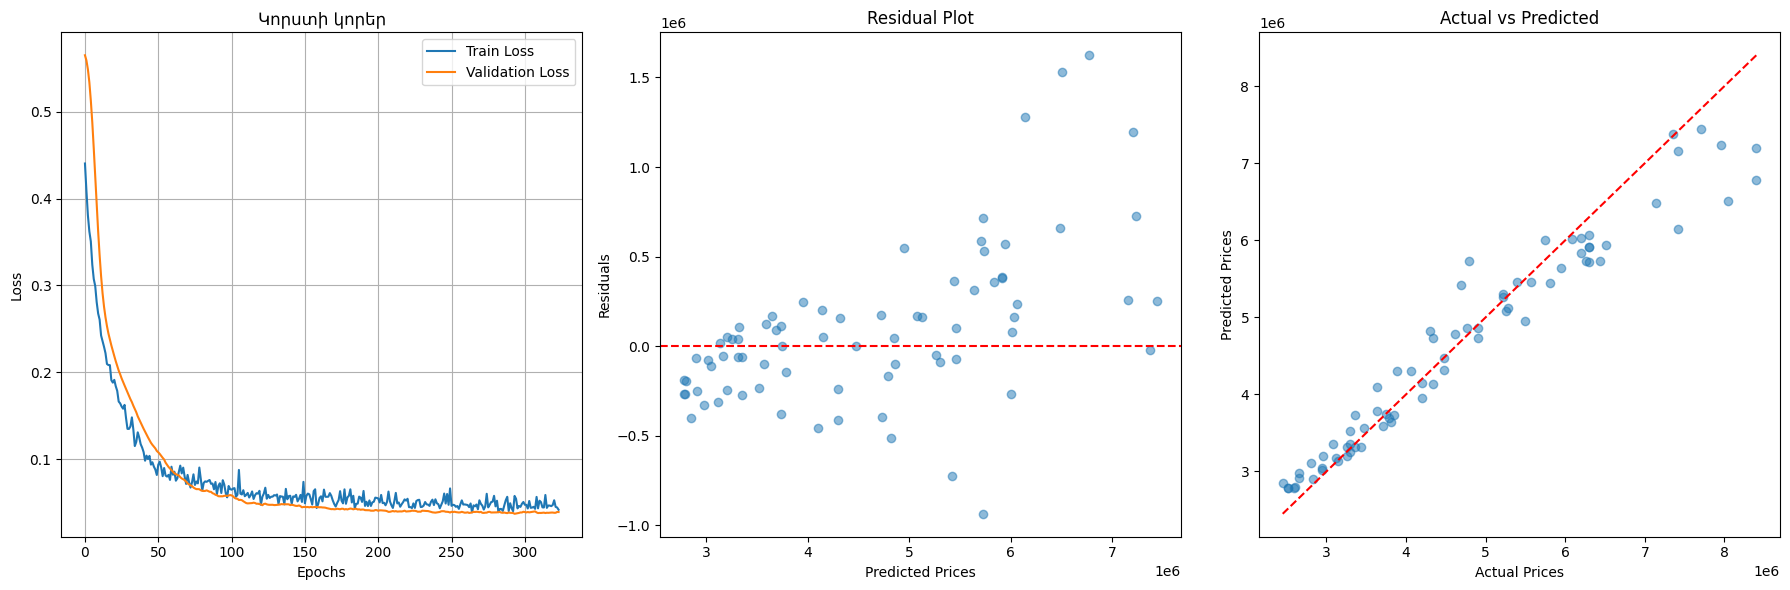

In [26]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

file_path = "/kaggle/input/housing/Housing.csv"
df = pd.read_csv(file_path)

df.dropna(inplace=True)
price_q1, price_q3 = df['price'].quantile([0.05, 0.95])
df = df[(df['price'] >= price_q1) & (df['price'] <= price_q3)]

df['price'] = np.log1p(df['price'])
df['area'] = np.log1p(df['area'])

df = pd.get_dummies(df, columns=["mainroad", "guestroom", "basement", "hotwaterheating",
                                "airconditioning", "prefarea", "furnishingstatus", "stories", "parking"], 
                   drop_first=True, dtype=int)

df['price_per_sqft'] = df['price'] / df['area']
df['total_rooms'] = df['bedrooms'] + df['bathrooms']
df['area_per_room'] = df['area'] / (df['bedrooms'] + df['bathrooms'] + 1e-6)
df['size_quality_interaction'] = df['area'] * df['airconditioning_yes']

# Լուծում parking-ի համար
parking_cols = [col for col in df.columns if col.startswith('parking_')]
df['luxury_score'] = df['airconditioning_yes'] + df['prefarea_yes'] 
if parking_cols:
    df['luxury_score'] += df[parking_cols].sum(axis=1)

X = df.drop(columns=["price"]).values
y = df["price"].values.reshape(-1, 1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler_X = RobustScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

class AdvancedHousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.4),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AdvancedHousePriceModel(X_train.shape[1]).to(device)
criterion = nn.HuberLoss(delta=1.0)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

epochs = 1500
best_val_loss = float('inf')
patience = 30
trigger_times = 0

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_tensor.to(device))
        val_loss = criterion(val_preds, y_val_tensor.to(device)).item()
        val_losses.append(val_loss)
        scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            break
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    test_preds = model(X_test_tensor.to(device)).cpu().numpy()
    train_preds = model(X_train_tensor.to(device)).cpu().numpy()

test_preds_unscaled = np.expm1(scaler_y.inverse_transform(test_preds))
y_test_unscaled = np.expm1(scaler_y.inverse_transform(y_test))
train_preds_unscaled = np.expm1(scaler_y.inverse_transform(train_preds))
y_train_unscaled = np.expm1(scaler_y.inverse_transform(y_train))

rmse_test = np.sqrt(mean_squared_error(y_test_unscaled, test_preds_unscaled))
r2_test = r2_score(y_test_unscaled, test_preds_unscaled)
mae_test = mean_absolute_error(y_test_unscaled, test_preds_unscaled)

rmse_train = np.sqrt(mean_squared_error(y_train_unscaled, train_preds_unscaled))
r2_train = r2_score(y_train_unscaled, train_preds_unscaled)

print(f"\n📊 Վերջնական արդյունքներ:")
print(f"✅ Test RMSE: {rmse_test:.2f}")
print(f"✅ Test R²: {r2_test:.4f}")
print(f"✅ Test MAE: {mae_test:.2f}")
print(f"\n🚂 Train RMSE: {rmse_train:.2f}")
print(f"🚂 Train R²: {r2_train:.4f}")

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Կորստի կորեր')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
residuals = y_test_unscaled - test_preds_unscaled
plt.scatter(test_preds_unscaled, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')

plt.subplot(1, 3, 3)
plt.scatter(y_test_unscaled, test_preds_unscaled, alpha=0.5)
plt.plot([min(y_test_unscaled), max(y_test_unscaled)], 
         [min(y_test_unscaled), max(y_test_unscaled)], 
         color='red', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

plt.tight_layout()
plt.show()

torch.save({
    'model_state_dict': model.state_dict(),
    'scaler_X': scaler_X,
    'scaler_y': scaler_y,
    'input_dim': X_train.shape[1]
}, 'house_price_model.pth')

def predict_price(features):
    model.eval()
    features_scaled = scaler_X.transform([features])
    features_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        prediction = model(features_tensor).cpu().numpy()
    return np.expm1(scaler_y.inverse_transform(prediction))[0][0]
